# Задача 1. Оптимизация воронки конверсии

Наша первая задача будет заключаться в **оптимизации воронки конверсии** и **выявлении "точек утечки"** с коммерческой точки зрения относительно категорий товаров

## Подготовка к исследованию

Импортируем все необходимые нам библиотеки, подключаем Google Drive, где хранятся очищенные выборки, как файловую систему:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# загружаем датафрейм с очищенной выборкой
df = pd.read_csv('/content/drive/MyDrive/analytics_project/cl_sample_full.csv')
display(df.head())

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,price_segment
0,2019-10-01 00:02:19+00:00,view,29800033,2.053014e+18,furniture.living_room.chair,NaN,169.86,555306597,3a374230-2ac7-429d-8fe0-92ad8fdc6b28,$100-200
1,2019-10-01 00:03:14+00:00,view,29800030,2.053014e+18,furniture.living_room.chair,NaN,169.86,555306597,3a374230-2ac7-429d-8fe0-92ad8fdc6b28,$100-200
2,2019-10-01 02:17:18+00:00,view,21409330,2.053014e+18,electronics.clocks,casio,36.29,553942405,3460ca9c-ade7-4e17-98c4-89e53015f270,<$50
3,2019-10-01 02:18:22+00:00,view,1005115,2.053014e+18,electronics.smartphone,apple,975.57,526763765,4a35be70-22fe-4602-8f3b-98bb163dca03,$500-1000
4,2019-10-01 02:20:12+00:00,view,6600729,2.053014e+18,computers.components.memory,hyperx,49.16,555338553,c67436df-ad24-4046-af92-6c7514b6b158,<$50


In [ ]:
# для удобства создадим укрупненные категории по первому названию в category_code
df['category_parent'] = df['category_code'].str.split('.').str[0]

print("Пример укрупнённых категорий:")
display(df[['category_code', 'category_parent']].head(10))

Пример укрупнённых категорий:


,category_code,category_parent
0,furniture.living_room.chair,furniture
1,furniture.living_room.chair,furniture
2,electronics.clocks,electronics
3,electronics.smartphone,electronics
4,computers.components.memory,computers
5,electronics.smartphone,electronics
6,unknown,unknown
7,electronics.smartphone,electronics
8,electronics.smartphone,electronics
9,electronics.audio.headphone,electronics


## Конверсия и drop-off

Считаем конверсию и drop-off по укрупненным категориям: количество уникальных пользователей, прошедших путь от просмотра до покупки, а также процентное соотношение "отвалившихся" пользователей на каждом этапе по каждой категории

In [ ]:
# для сохранности датафрейма создадим его копию
df_copy = df.copy()


# считаем количество уникальных пользователей на каждом этапе по категориям
conversion_data = (
    df_copy
    .pivot_table(
        index='category_parent',
        columns='event_type',
        values='user_id',
        aggfunc='nunique',
        fill_value=0
    )
    .reindex(columns=['view', 'cart', 'purchase'])  # чтобы порядок был правильным
)

# переименовываем колонки
conversion_data.columns = ['views', 'carts', 'purchases']
conversion_data = conversion_data.reset_index()

# считаем конверсии
conversion_data['conv_view_to_cart'] = (
    100 * conversion_data['carts'] / conversion_data['views']
).round(2)

conversion_data['conv_cart_to_purchase'] = (
    100 * conversion_data['purchases'] / conversion_data['carts']
).round(2)

conversion_data['conv_view_to_purchase'] = (
    100 * conversion_data['purchases'] / conversion_data['views']
).round(2)

# заменяем inf и NaN на 0 (если было деление на 0)
conversion_data = conversion_data.replace([float('inf'), -float('inf')], 0).fillna(0)

# сортируем по общей конверсии (view → purchase)
conversion_data = conversion_data.sort_values('conv_view_to_purchase', ascending=False)

# считаем drop-off на каждом этапе воронки
conversion_data['drop_off_view_to_cart'] = 100 - conversion_data['conv_view_to_cart']
conversion_data['drop_off_cart_to_purchase'] = 100 - conversion_data['conv_cart_to_purchase']
conversion_data['drop_off_view_to_purchase'] = 100 - conversion_data['conv_view_to_purchase']

print("Конверсия и drop-off по укрупненным категориям:")
display(conversion_data)

Конверсия и drop-off по укрупненным категориям:


,category_parent,views,carts,purchases,conv_view_to_cart,conv_cart_to_purchase,conv_view_to_purchase,drop_off_view_to_cart,drop_off_cart_to_purchase,drop_off_view_to_purchase
7,electronics,9029,1961,1325,21.72,67.57,14.67,78.28,32.43,85.33
2,appliances,3494,508,406,14.54,79.92,11.62,85.46,20.08,88.38
13,unknown,8308,926,809,11.15,87.37,9.74,88.85,12.63,90.26
4,computers,1647,171,129,10.38,75.44,7.83,89.62,24.56,92.17
10,medicine,27,3,2,11.11,66.67,7.41,88.89,33.33,92.59
12,stationery,15,1,1,6.67,100.00,6.67,93.33,0.00,93.33
5,construction,749,65,41,8.68,63.08,5.47,91.32,36.92,94.53
3,auto,1023,63,51,6.16,80.95,4.99,93.84,19.05,95.01
9,kids,688,36,34,5.23,94.44,4.94,94.77,5.56,95.06
8,furniture,1438,54,44,3.76,81.48,3.06,96.24,18.52,96.94


Для визуализации результатов построим графики общей конверсии и конверсии по этапам:

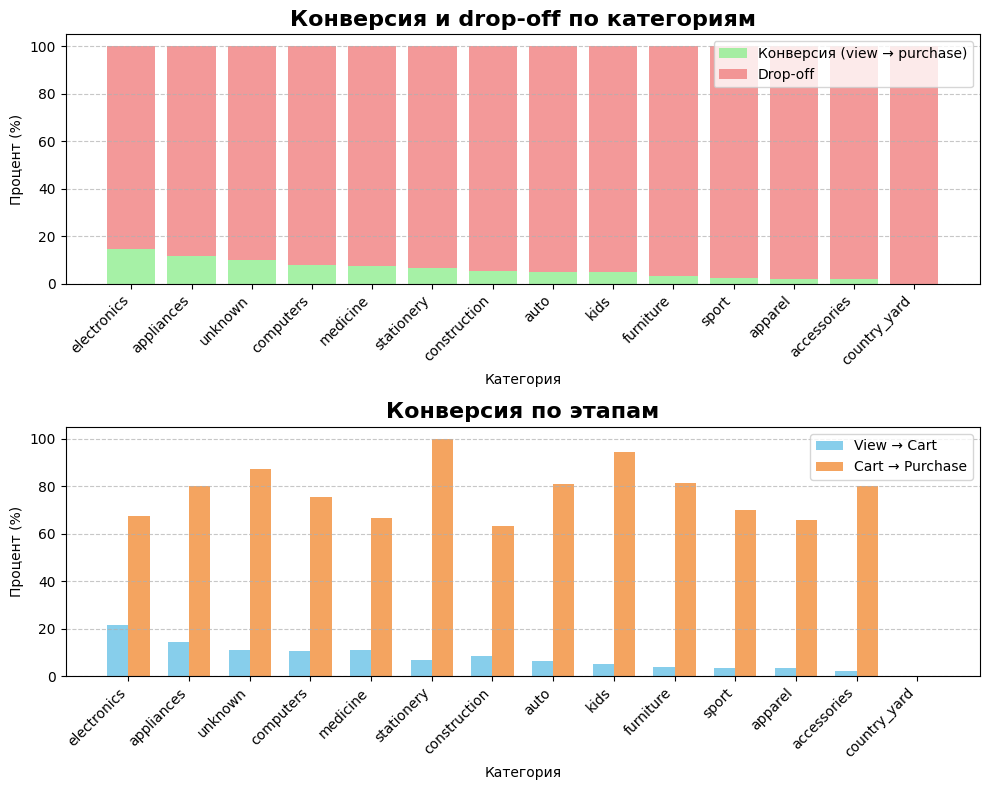

In [ ]:
# создаем фигуру
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# подготовка данных
categories = conversion_data['category_parent']
x = list(range(len(categories)))  # позиции на оси X
width = 0.35    # ширина столбца для группированной диаграммы


# для начала строим график общей конверсии и drop-off
# будем использовать столбчатую диаграмму с накоплением, т.к. в сумме конверсия и drop-off = 100%
# столбцы: сначала конверсия, потом drop-off

bars1 = ax1.bar(categories, conversion_data['conv_view_to_purchase'],
               label='Конверсия (view → purchase)', color='lightgreen', alpha=0.8)

bars2 = ax1.bar(categories, conversion_data['drop_off_view_to_purchase'],
               bottom=conversion_data['conv_view_to_purchase'],  label='Drop-off', color='lightcoral', alpha=0.8)

# оформляем
ax1.set_title('Конверсия и drop-off по категориям', fontsize=16, fontweight='bold')
ax1.set_ylabel('Процент (%)')
ax1.set_xlabel('Категория')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')


# строим второй график - конверсии по этапам
# будем использовать группированную столбчатую диаграмму для более явного отображения разницы

# столбцы: используем смещение столбцов относительно засечек
ax2.bar([i - width/2 for i in x], conversion_data['conv_view_to_cart'], width, label='View → Cart', color='skyblue')
ax2.bar([i + width/2 for i in x], conversion_data['conv_cart_to_purchase'], width, label='Cart → Purchase', color='sandybrown')

# оформляем
ax2.set_xlabel('Категория')
ax2.set_ylabel('Процент (%)')
ax2.set_title('Конверсия по этапам', fontweight='bold', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

**Выводы по воронке конверсии:**

- **electronics** (14.67%) и **appliances** (11.62%) - показывают высокую эффективность, это категории с наибольшим потенциалом роста

- в категории **unknown** относительно высокая конверсия (9.74%) и большое количество просмотров (8308) - это значит, что значительная часть пользовательского поведения остается вне анализа, что является утечкой данных

- конверсия из корзины в покупку высокая почти во всех категориях (63-100%) → UX при оплате работает хорошо, большинство пользователей, добавивших товар в корзину, покупают его

- главная проблема - низкая конверсия из просмотра в корзину (в среднем меньше 20%) → нужно работать над доверием, ценой, описанием, сравнением

## Потенциальная выручка

Далее посчитаем *актуальную* и *упущенную* выручку по укрупненным категориям. *Потенциальной* выручкой будем считать выручку с товаров, если бы все пользователи, положившие в корзину, купили:

In [ ]:
 # фильтруем cart и purchase
df_cart = df_copy[df_copy['event_type'] == 'cart']
df_purchase = df_copy[df_copy['event_type'] == 'purchase']

# считаем выручку по категориям
revenue_cart = df_cart.groupby('category_parent')['price'].sum().rename('potential_revenue')
revenue_purchase = df_purchase.groupby('category_parent')['price'].sum().rename('actual_revenue')

# объединяем
revenue_summary = pd.concat([revenue_cart, revenue_purchase], axis=1).fillna(0)

# считаем упущенную выручку
revenue_summary['lost_revenue'] = revenue_summary['potential_revenue'] - revenue_summary['actual_revenue']

# заменяем отрицательные значения упущенной выручки на 0
revenue_summary['lost_revenue'] = revenue_summary['lost_revenue'].clip(lower=0)

# добавляем процент упущенной выручки
revenue_summary['pct_lost'] = (
    100 * revenue_summary['lost_revenue'] / revenue_summary['potential_revenue']
).round(2).fillna(0)

# посчитаем общую актуальную и упущенную выручки
total_actual_revenue = revenue_summary['actual_revenue'].sum()
total_lost_revenue = revenue_summary['lost_revenue'].sum()

# добавим процент от общей выручки
revenue_summary['pct_of_total_revenue'] = (100 * revenue_summary['actual_revenue'] / total_actual_revenue).round(2)

# сортируем по упущенной выручке
revenue_summary = revenue_summary.sort_values('lost_revenue', ascending=False)

revenue_summary.reset_index(inplace=True)
print("Анализ выручки по укрупненным категориям:")
display(revenue_summary)

print(f"Общая выручка: {total_actual_revenue.round(2)}")
print(f"Упущенная выручка: {total_lost_revenue.round(2)}")

Анализ выручки по укрупненным категориям:


,category_parent,potential_revenue,actual_revenue,lost_revenue,pct_lost,pct_of_total_revenue
0,electronics,2550808.68,1221933.97,1328874.71,52.10,72.99
1,unknown,312178.84,189790.73,122388.11,39.20,11.34
2,appliances,233498.57,114232.58,119265.99,51.08,6.82
3,computers,160781.48,104083.19,56698.29,35.26,6.22
4,furniture,26426.00,13929.73,12496.27,47.29,0.83
5,sport,14054.76,1740.17,12314.59,87.62,0.10
6,construction,17466.20,6190.26,11275.94,64.56,0.37
7,apparel,9037.93,4897.49,4140.44,45.81,0.29
8,kids,8590.58,5371.36,3219.22,37.47,0.32
9,auto,14404.34,11523.65,2880.69,20.00,0.69


Общая выручка: 1674136.35
Упущенная выручка: 1674283.42


Главное замечание - упущенная выручка равна актуальной, это значит, что оптимизируя ресурсы, мы можем увеличить выручку в 2 раза

Построим также график актуальной и упущенной выручки для визуализации:

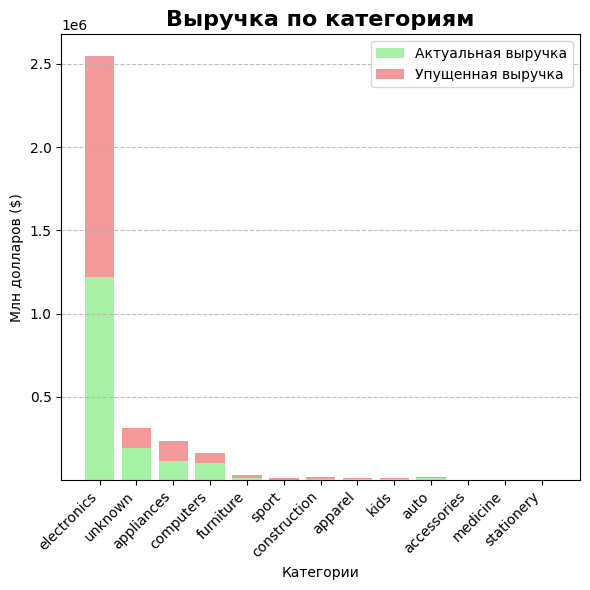

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(revenue_summary['category_parent'], revenue_summary['actual_revenue'],
        label='Актуальная выручка', color='lightgreen', alpha=0.8)
plt.bar(revenue_summary['category_parent'], revenue_summary['lost_revenue'],
        label='Упущенная выручка', bottom=revenue_summary['actual_revenue'], color='lightcoral', alpha=0.8)

plt.title('Выручка по категориям', fontsize=16, fontweight='bold')
plt.xlabel('Категории')
plt.ylabel('Млн долларов ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.legend()

plt.tight_layout()
plt.show()

Невооруженным глазом видим, что **electronics** является главным концентратом выручки магазина - 73%.
Также категории **unknown**, **appliances** и **computers** представляют повышенный интерес.
Рассмотрим остальные категории отдельно

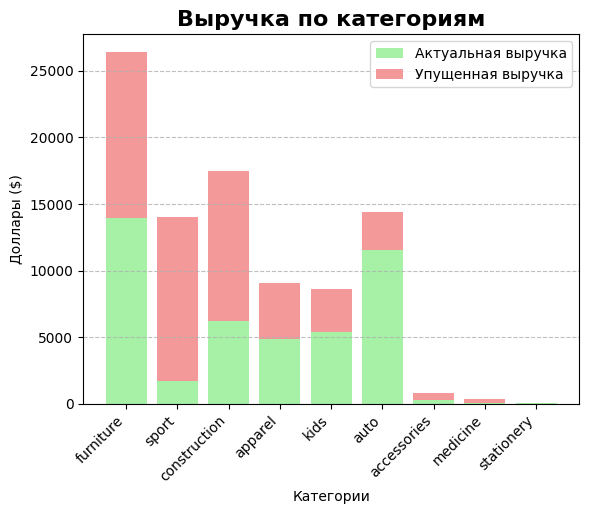

In [ ]:
# отделяем часть сводной таблицы revenue_summary с категориями с актуальной выручкой, меньшей 100000
revenue_part = revenue_summary[revenue_summary['actual_revenue'] < 100000]

bars1 = plt.bar(revenue_part['category_parent'], revenue_part['actual_revenue'],
               label='Актуальная выручка', color='lightgreen', alpha=0.8)
bars2 = plt.bar(revenue_part['category_parent'], revenue_part['lost_revenue'],
               bottom=revenue_part['actual_revenue'], label='Упущенная выручка', color='lightcoral', alpha=0.8)
plt.title('Выручка по категориям', fontsize=16, fontweight='bold')
plt.xlabel('Категории')
plt.ylabel('Доллары ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.legend()

plt.show()

**Выводы по анализу потенциальной выручки:**
- **electronics** - самая продуктивная категория, ее выручка составляет 73% общей выручки сайта, но и потери объемны - 52%
- **unknown** продолжает являться слепой зоной и в коммерческом плане: $122k упущены - и мы не можем с этим работать, пока не получим информацию об этих товарах
- **appliances**, **computers** - высокопотенциальные категории с относительно большой долей в общей выручке - 12%, при этом **computers** еще и имеет небольшой процент упущенной выручки - всего 35% - пользователи охотно покупают в этой категории
- **accessories**, **medicine** и **stationery** приносят меньше всего выручки
- все остальные категории находятся примерно на одном уровне, не особо значительном для внимания

## Суммарные выводы и рекомендации

Объединим анализ конверсий и потенциальной выручки в один датафрейм, чтобы сделать общие выводы по категориям:

In [ ]:
final_data = pd.merge(
    conversion_data,
    revenue_summary,
    on='category_parent',
    how='left'
).fillna(0)

display(final_data)

,category_parent,views,carts,purchases,conv_view_to_cart,conv_cart_to_purchase,conv_view_to_purchase,drop_off_view_to_cart,drop_off_cart_to_purchase,drop_off_view_to_purchase,potential_revenue,actual_revenue,lost_revenue,pct_lost,pct_of_total_revenue
0,electronics,9029,1961,1325,21.72,67.57,14.67,78.28,32.43,85.33,2550808.68,1221933.97,1328874.71,52.10,72.99
1,appliances,3494,508,406,14.54,79.92,11.62,85.46,20.08,88.38,233498.57,114232.58,119265.99,51.08,6.82
2,unknown,8308,926,809,11.15,87.37,9.74,88.85,12.63,90.26,312178.84,189790.73,122388.11,39.20,11.34
3,computers,1647,171,129,10.38,75.44,7.83,89.62,24.56,92.17,160781.48,104083.19,56698.29,35.26,6.22
4,medicine,27,3,2,11.11,66.67,7.41,88.89,33.33,92.59,331.54,97.43,234.11,70.61,0.01
5,stationery,15,1,1,6.67,100.00,6.67,93.33,0.00,93.33,25.48,25.48,0.00,0.00,0.00
6,construction,749,65,41,8.68,63.08,5.47,91.32,36.92,94.53,17466.20,6190.26,11275.94,64.56,0.37
7,auto,1023,63,51,6.16,80.95,4.99,93.84,19.05,95.01,14404.34,11523.65,2880.69,20.00,0.69
8,kids,688,36,34,5.23,94.44,4.94,94.77,5.56,95.06,8590.58,5371.36,3219.22,37.47,0.32
9,furniture,1438,54,44,3.76,81.48,3.06,96.24,18.52,96.94,26426.00,13929.73,12496.27,47.29,0.83


Построим scatter-plot, чтобы увидеть категории в контексте трех факторов: конверсии из просмотра в корзину, упущенной выручки и процента упущенной выручки:

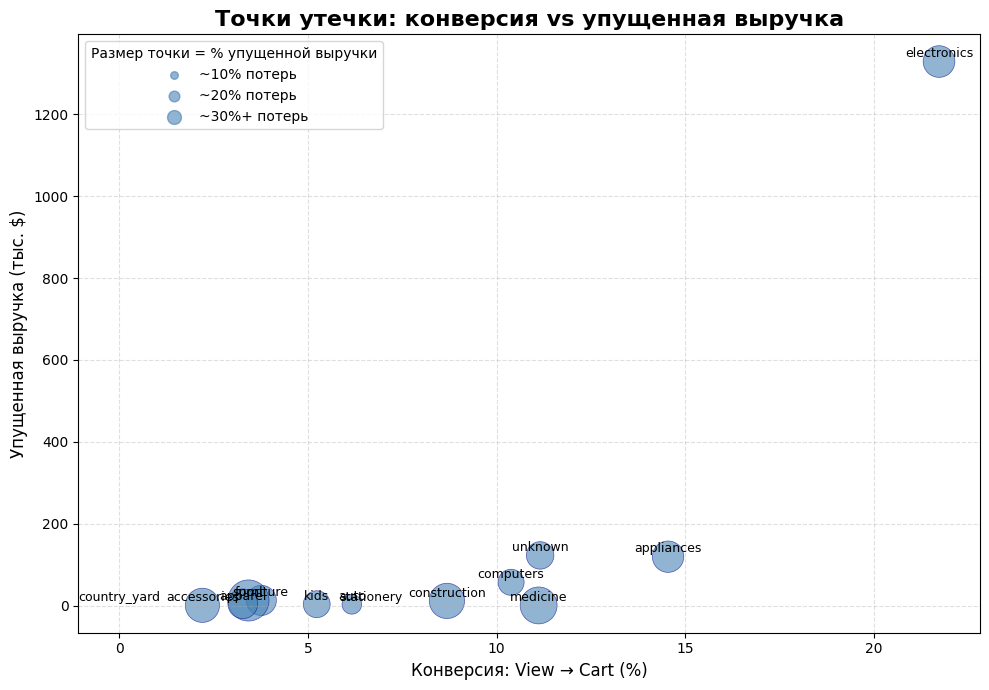

In [ ]:
# убедимся, что final_data отсортирован по lost_revenue для лучшего восприятия
final_data_sorted = final_data.sort_values('lost_revenue', ascending=False)

plt.figure(figsize=(10, 7))

# создаём scatter plot
scatter = plt.scatter(
    x=final_data_sorted['conv_view_to_cart'],           # Ось X: конверсия view → cart (%)
    y=final_data_sorted['lost_revenue'] / 1000,         # Ось Y: упущенная выручка (в тыс. $)
    s=final_data_sorted['pct_lost'] * 10,               # Размер точки: % потерь (масштабируем)
    alpha=0.6,
    color='steelblue',
    edgecolors='darkblue',
    linewidth=0.5
)

# подписи точек (названия категорий)
for i in final_data_sorted.index:
    plt.text(
        final_data_sorted.loc[i, 'conv_view_to_cart'],
        final_data_sorted.loc[i, 'lost_revenue'] / 1000 + 3,  # чуть выше точки
        final_data_sorted.loc[i, 'category_parent'],
        fontsize=9,
        ha='center',
        va='bottom'
    )

# оформление
plt.title('Точки утечки: конверсия vs упущенная выручка', fontsize=16, fontweight='bold')
plt.xlabel('Конверсия: View → Cart (%)', fontsize=12)
plt.ylabel('Упущенная выручка (тыс. $)', fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# легенда для размера точек (процент потерь)
legend_elements = [
    plt.scatter([], [], s=30,  alpha=0.6, color='steelblue', label='~10% потерь'),
    plt.scatter([], [], s=60,  alpha=0.6, color='steelblue', label='~20% потерь'),
    plt.scatter([], [], s=100, alpha=0.6, color='steelblue', label='~30%+ потерь')
]
plt.legend(title="Размер точки = % упущенной выручки", loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

Категория electronics вполне ожидаемо превосходит все показатели - самая высокая конверсия в корзину и самая большая упущенная выручка.
Теперь исключим эту категорию и посмотрим на остальной график:

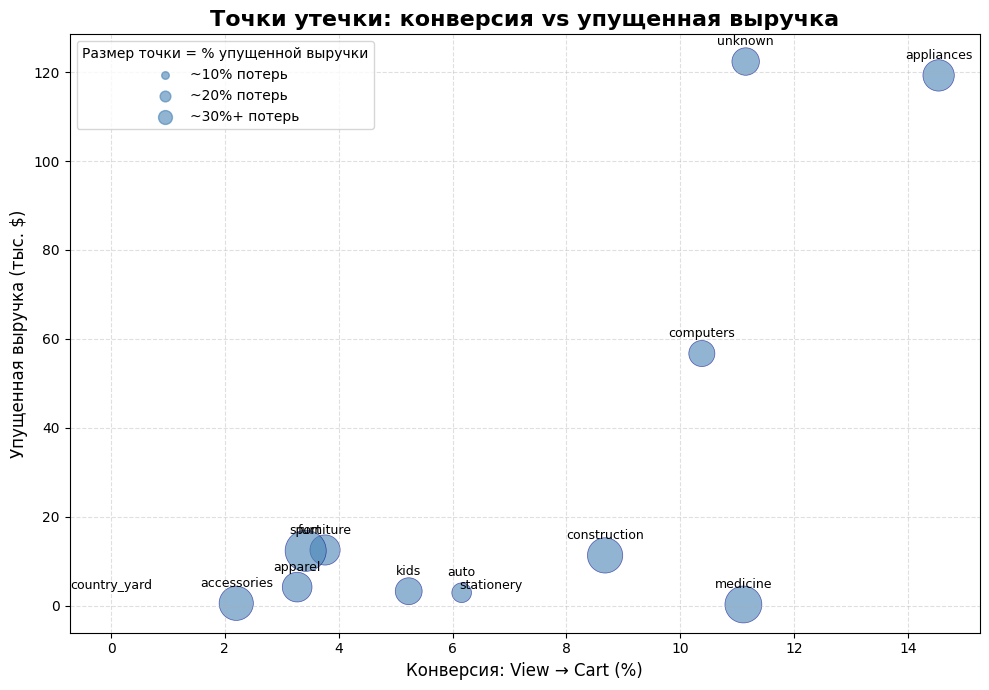

In [ ]:
# отделим от основного фрейма категории без electronics
final_data_sorted = final_data_sorted[final_data_sorted['category_parent'] != 'electronics']

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    x=final_data_sorted['conv_view_to_cart'],
    y=final_data_sorted['lost_revenue'] / 1000,
    s=final_data_sorted['pct_lost'] * 10,
    alpha=0.6,
    color='steelblue',
    edgecolors='darkblue',
    linewidth=0.5
)


for i in final_data_sorted.index:
    plt.text(
        final_data_sorted.loc[i, 'conv_view_to_cart'],
        final_data_sorted.loc[i, 'lost_revenue'] / 1000 + 3,
        final_data_sorted.loc[i, 'category_parent'],
        fontsize=9,
        ha='center',
        va='bottom'
    )


plt.title('Точки утечки: конверсия vs упущенная выручка', fontsize=16, fontweight='bold')
plt.xlabel('Конверсия: View → Cart (%)', fontsize=12)
plt.ylabel('Упущенная выручка (тыс. $)', fontsize=12)
plt.grid(alpha=0.4, linestyle='--')


legend_elements = [
    plt.scatter([], [], s=30,  alpha=0.6, color='steelblue', label='~10% потерь'),
    plt.scatter([], [], s=60,  alpha=0.6, color='steelblue', label='~20% потерь'),
    plt.scatter([], [], s=100, alpha=0.6, color='steelblue', label='~30%+ потерь')
]
plt.legend(title="Размер точки = % упущенной выручки", loc='upper left', frameon=True)


plt.tight_layout()
plt.show()

**Выводы по графику:**
- electronics - огромный масштаб ($1.3М упущенной выручки), конверсия средняя, большой процент потерь = большой потенциал для роста
- appliances - много денег упущено (\$122k), конверсия средняя, но в покупку - большая(80%), поэтому корзина - главный фокус
- unknown - слепая зона с деньгами и небольшой конверсией - но больше сказать нельзя ничего, нет информации
- computers - работает хорошо, упущенных денег не так много
- country_yard и stationery - потерь нет совсем, но нет и покупок - стоит изучить товары, возможно проблема в карточках товара
- остальные категории не представляют особой значимости

**Рекомендации:**
- сфокусироваться на **electronics** - эта категория даст максимальный финансовый профит, у нее наилучшая конверсия в корзину, поэтому работаем с покупкой - дожимаем клиентов, например, баннерами "Осталось N штук!"
- провести аудит данных в категории **unknown** - распознать истинные категории товаров, чтобы закрыть слепую зону
- исправить вероятную ошибку в логировании данных при записи категории товара
- продолжать развивать **appliances** и **computers** - у них хорошее пространство для роста
- снизить интенсивность инвестиций в **accessories**, **medicine** и **stationery**, оставив их как канал допродаж
- основной стратегический фокус по всем категориям - на увеличение добавлений в корзину, например, помогая со сравнением товаров: можно запустить рассылку "Вы смотрели этот товар - вот предложения с лучшей ценой"